In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Load the cleaned dataset
data = pd.read_csv('cleaned_data.csv')

# Create 'is_paid' feature: 0 for free, 1 for paid
data['is_paid'] = data['Pricing'].apply(lambda x: 0 if x == 0.0 else 1)

# Extract 'Month' from 'Release Date'
data['Release Date'] = pd.to_datetime(data['Release Date'], errors='coerce')
data['Release Month'] = data['Release Date'].dt.month

# Filter to only paid games (is_paid == 1)
data_paid = data[data['is_paid'] == 1].reset_index(drop=True)

# Select features and target
features = ['Game Genre', 'Developer', 'Release Month', 'Pricing']
target = 'Rating'

X = data_paid[features]
y = data_paid[target]

# Define categorical and numerical features
categorical_features = ['Game Genre', 'Developer']
numerical_features = ['Release Month', 'Pricing']

# Preprocessing pipelines for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ]
)

# Apply preprocessing to the features
X_preprocessed = preprocessor.fit_transform(X)

# Convert the preprocessed features to a DataFrame
encoded_cat_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
encoded_num_features = numerical_features
all_features = list(encoded_cat_features) + encoded_num_features

X_preprocessed_df = pd.DataFrame(X_preprocessed.toarray(), columns=all_features)

# Reset the index of X_preprocessed_df to align with y
X_preprocessed_df = X_preprocessed_df.reset_index(drop=True)

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed_df, y, test_size=0.2, random_state=18
)

# Display the sizes of the splits
print(f'Training set size: {X_train.shape[0]} samples')
print(f'Test set size: {X_test.shape[0]} samples')


Training set size: 32808 samples
Test set size: 8202 samples


### Explain Code

1. **Imports and Data Loading**
   - **Libraries Imported:**
     - **pandas (`pd`)**: Utilized for data manipulation and analysis, particularly for handling DataFrame structures.
     - **numpy (`np`)**: Employed for numerical operations and handling array data.
     - **OneHotEncoder** from `sklearn.preprocessing`: Converts categorical variables into a format that can be provided to machine learning algorithms.
     - **ColumnTransformer** from `sklearn.compose`: Applies different preprocessing and feature transformation pipelines to different subsets of features.
     - **Pipeline** from `sklearn.pipeline`: Chains multiple processing steps into a single workflow to ensure consistency.
     - **SimpleImputer** from `sklearn.impute`: Handles missing values by imputing them based on a specified strategy.
     - **train_test_split** from `sklearn.model_selection`: Splits the dataset into training and testing subsets for model evaluation.
   
   - **Data Loading and Feature Engineering:**
     - **Loading Data**: Reads the cleaned CSV file into a pandas DataFrame named `data`.
     - **Creating `is_paid` Column**: Introduces a new binary column `is_paid` where:
       - `0` indicates a free game (`Pricing` equals `0.0`).
       - `1` indicates a paid game (`Pricing` not equal to `0.0`).

2. **Date and Feature Creation**
   - **Processing Release Dates:**
     - **Conversion**: Transforms the `Release Date` column to datetime objects, ensuring consistent date formats and handling any parsing errors by coercing invalid entries to `NaT` (Not a Time).
     - **Extracting Month**: Derives the release month from the `Release Date` and stores it in a new column `Release Month`.
   
   - **Filtering Data:**
     - **Selecting Free Games**: Filters the DataFrame to include only free games (`is_paid == 0`), focusing the analysis on this subset.
   
   - **Selecting Features and Target:**
     - **Features**: Chooses `Game Genre`, `Developer`, and `Release Month` as predictor variables.
     - **Target**: Defines `Rating` as the response variable.
     - **Alignment**: Resets the index of the target variable `y` to ensure it aligns with the feature DataFrame `X` after filtering.

3. **Preprocessing Setup**
   - **Categorical and Numerical Features:**
     - **Categorical Features**: Identifies `Game Genre` and `Developer` as categorical predictors that require encoding.
     - **Numerical Features**: Recognizes `Release Month` as a numerical predictor that may require imputation.
   
   - **Creating Preprocessing Pipelines:**
     - **Categorical Transformer Pipeline:**
       - **Imputation**: Uses `SimpleImputer` with the strategy set to `most_frequent` to fill in missing values with the most common category.
       - **Encoding**: Applies `OneHotEncoder` to convert categorical variables into binary indicators, handling any unknown categories gracefully by ignoring them.
     
     - **Numerical Transformer Pipeline:**
       - **Imputation**: Utilizes `SimpleImputer` with the strategy set to `mean` to replace missing numerical values with the average of each column.
   
   - **Combining Transformers:**
     - **ColumnTransformer**: Integrates the categorical and numerical transformers, ensuring that each subset of features is processed appropriately. This setup allows for simultaneous and distinct preprocessing of different feature types within a single workflow.

4. **Transformation and DataFrame Creation**
   - **Applying Preprocessing:**
     - **Fit and Transform**: Applies the `ColumnTransformer` to the feature DataFrame `X`, fitting the transformers to the data and transforming it accordingly. The result is a NumPy array containing the processed features.
   
   - **Creating a New DataFrame:**
     - **Feature Names Extraction**: Retrieves the names of the one-hot-encoded categorical features and combines them with the numerical feature names to form a comprehensive list of all feature names.
     - **DataFrame Conversion**: Converts the transformed NumPy array into a pandas DataFrame `X_preprocessed_df`, assigning the extracted feature names as column headers for clarity and ease of use in subsequent modeling steps.
     - **Index Alignment**: Resets the index of `X_preprocessed_df` to ensure it aligns perfectly with the target variable `y`, maintaining consistency across the dataset.

5. **Train-Test Split**
   - **Splitting the Dataset:**
     - **Training and Testing Sets**: Divides the preprocessed features `X_preprocessed_df` and the target variable `y` into training and testing subsets using an 80/20 split. This means 80% of the data is used for training the model, and 20% is reserved for evaluating its performance.
     - **Random State**: Sets the `random_state` parameter to `18` to ensure reproducibility of the split, allowing the results to be consistent across multiple runs.
   
   - **Outputting Split Information:**
     - **Training Set Size**: Prints the number of samples in the training set, providing insight into the amount of data available for model training.
     - **Test Set Size**: Prints the number of samples in the test set, indicating the size of the data reserved for model evaluation.


In [2]:
# Parameter grids for each model
param_grids = {
    'Ridge': {
        'fit_intercept': [True, False],
        'normalize': [True, False],
        'alpha': [0.1, 1]
    },
    'Lasso': {
        'alpha': [0.01, 0.1, 1, 10]
    }
}

### Explain Code

1. **Parameter Grid Definition**
   - **Purpose:**
     - Defines a dictionary `param_grids` that specifies the hyperparameters to be tested for each regression model (Ridge and Lasso). This structured approach facilitates systematic exploration of different hyperparameter values to identify the optimal model configuration.
   
   - **Ridge Regression:**
     - **`fit_intercept`:**
       - **Description:** Determines whether the Ridge regression model should calculate an intercept (`True`) or assume it to be zero (`False`).
       - **Impact:** Including an intercept allows the model to better fit data that does not pass through the origin, enhancing its flexibility and accuracy.
     
     - **`normalize`:**
       - **Description:** A deprecated parameter that was previously used to specify whether the input features should be normalized before fitting the model.
       - **Impact:** Modern practices recommend handling feature normalization within preprocessing pipelines rather than relying on model parameters. This ensures more consistent and flexible data preprocessing.
     
     - **`alpha`:**
       - **Description:** Controls the strength of the L2 regularization applied by Ridge regression. It determines the extent to which coefficients are shrunk towards zero.
       - **Impact:** 
         - **Low `alpha` (e.g., 0.1):** Results in weaker regularization, allowing the model to fit the training data more closely but potentially risking overfitting.
         - **High `alpha` (e.g., 1):** Imposes stronger regularization, which can prevent overfitting by penalizing large coefficients but may lead to underfitting if set too high.

   - **Lasso Regression:**
     - **`alpha`:**
       - **Description:** Controls the strength of the L1 regularization applied by Lasso regression. It influences both the degree of coefficient shrinkage and feature selection.
       - **Impact:**
         - **Low `alpha` (e.g., 0.01):** Results in minimal regularization, allowing most features to retain significant coefficients. This can capture more complex patterns but may include irrelevant features.
         - **High `alpha` (e.g., 10):** Enforces strong regularization, driving some coefficients to exactly zero and effectively performing feature selection. This simplifies the model and can improve interpretability but may exclude relevant predictors if set excessively high.

2. **Usage in Model Tuning**
   - **Systematic Exploration:**
     - The `param_grids` dictionary enables an organized and exhaustive search over specified hyperparameter values for each model. By iterating through each combination, the tuning process can assess the impact of different settings on model performance.
   
   - **Model Comparison:**
     - By defining separate hyperparameters for Ridge and Lasso, the dictionary allows for a direct comparison of how each model responds to changes in regularization strength and other parameters. This facilitates the selection of the most appropriate model based on performance metrics.

3. **Integration with Cross-Validation**
   - **Cross-Validation Framework:**
     - The defined parameter grids are utilized within a cross-validation loop to evaluate each hyperparameter combination's effectiveness. By systematically training and validating models across different folds, the process ensures that the chosen hyperparameters generalize well to unseen data.
   
   - **Performance Assessment:**
     - For each combination of hyperparameters, cross-validation provides robust metrics (e.g., R², MSE) that inform whether the current settings improve or degrade model performance. This iterative evaluation is critical for identifying the optimal balance between bias and variance.

4. **Facilitating Automation and Scalability**
   - **Automation:**
     - The organized structure of `param_grids` allows for seamless integration with automated hyperparameter tuning methods, such as grid search or randomized search. This automation streamlines the tuning process, making it more efficient and less error-prone.
   
   - **Scalability:**
     - As more models or additional hyperparameters are introduced, the dictionary format supports easy expansion. New entries can be added without disrupting the existing structure, maintaining clarity and manageability in the tuning workflow.


In [3]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Hàm cross-validation cho hồi quy
def cross_validate_regression(model, X, y, k=5):
    fold_size = len(X) // k
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    scores = {'mse': [], 'rmse': [], 'r2': []}
    
    for fold in range(k):
        start = fold * fold_size
        end = start + fold_size if fold != k-1 else len(X)
        val_indices = indices[start:end]
        train_indices = np.concatenate([indices[:start], indices[end:]])
        
        # Convert X và y thành numpy arrays nếu là pandas DataFrame hoặc Series
        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.values
        if isinstance(y, (pd.DataFrame, pd.Series)):
            y = y.values
        
        X_train_cv, y_train_cv = X[train_indices], y[train_indices]
        X_val_cv, y_val_cv = X[val_indices], y[val_indices]
        
        model.fit(X_train_cv, y_train_cv)
        y_pred = model.predict(X_val_cv)
        
        mse = mean_squared_error(y_val_cv, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_val_cv, y_pred)
        
        scores['mse'].append(mse)
        scores['rmse'].append(rmse)
        scores['r2'].append(r2)
        
    avg_scores = {metric: np.mean(values) for metric, values in scores.items()}
    return avg_scores

### Explain Code

1. **Import Library**
   - **NumPy (`numpy` as `np`):**
     - **Purpose:** Provides support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays.
     - **Usage:** Utilized for numerical operations such as calculating the square root for RMSE (Root Mean Squared Error).
   
   - **scikit-learn’s Metrics:**
     - **`mean_squared_error`:**
       - **Purpose:** Computes the Mean Squared Error between actual and predicted values.
       - **Usage:** Measures the average of the squares of the errors, providing an indication of the model's prediction accuracy.
     - **`r2_score`:**
       - **Purpose:** Calculates the R-squared (coefficient of determination) regression score.
       - **Usage:** Represents the proportion of variance in the dependent variable that is predictable from the independent variables, indicating the goodness of fit.
   
   - **pandas (`pd`):**
     - **Purpose:** Offers data structures and data analysis tools for handling structured data.
     - **Usage:** Facilitates data manipulation and preparation, such as handling DataFrame structures and performing operations like shuffling indices.

2. **Function `cross_validate_regression`**

   - **Purpose:**
     - Implements a manual k-fold cross-validation procedure for regression models.
     - Evaluates the model's performance by calculating key regression metrics across multiple folds to ensure robustness and generalizability.
   
   - **Parameters:**
     - **`model`:** The regression model to be evaluated (e.g., Ridge, Lasso).
     - **`X`:** Feature matrix containing the independent variables.
     - **`y`:** Target vector containing the dependent variable.
     - **`k`** (default=5): The number of folds to be used in cross-validation.
   
   - **Steps:**
     
     1. **Calculate Fold Size:**
        - Determines the number of samples per fold by dividing the total number of samples by the number of folds (`k`).
     
     2. **Shuffle Dataset Indices:**
        - Creates an array of indices corresponding to the dataset samples and shuffles them to ensure randomness in fold assignments, preventing bias in the cross-validation process.
     
     3. **Initialize Scores Dictionary:**
        - Prepares a dictionary to store the Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared (R²) values for each fold.
     
     4. **Iterate Over Each Fold:**
        - Runs `k` iterations, each corresponding to a different validation fold.
        - Defines validation indices by selecting a subset of indices for validation.
        - Defines training indices by concatenating the remaining indices for training.
     
     5. **Convert Data to NumPy Arrays If Necessary:**
        - Ensures that the feature matrix (`X`) and target vector (`y`) are in NumPy array format, which is required for scikit-learn models. Converts them from pandas DataFrame or Series if necessary.
     
     6. **Split Data into Training and Validation Sets:**
        - Creates the training and validation subsets for the current fold based on the previously defined indices.
     
     7. **Train the Model and Make Predictions:**
        - Fits the regression model on the training subset.
        - Generates predictions for the validation subset using the trained model.
     
     8. **Calculate Error Metrics:**
        - Quantifies the average squared difference between the actual and predicted values (MSE).
        - Provides the square root of MSE (RMSE), offering error magnitude in the same units as the target variable.
        - Indicates the proportion of variance explained by the model (R²).
     
     9. **Store the Calculated Metrics:**
        - Appends the calculated MSE, RMSE, and R² values to their respective lists in the `scores` dictionary for later aggregation.
     
     10. **Compute Average Scores Across All Folds:**
         - Calculates the mean of each metric (MSE, RMSE, R²) across all folds to obtain an overall performance estimate.
         - Returns the average scores as a dictionary for further analysis or comparison.
   
   - **Return Value:**
     - A dictionary containing the average Mean Squared Error (`mse`), Root Mean Squared Error (`rmse`), and R-squared (`r2`) across all `k` folds, providing a summary of the model's performance.

In [4]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Initialize variables to store the best results and all tuning outcomes for Ridge
ridge_best_score = -np.inf
ridge_best_mse = np.inf
ridge_best_params = {}
ridge_results = []

# Tuning parameters Ridge Regression
for fit_intercept in param_grids['Ridge']['fit_intercept']:
    for normalize in [True, False]: 
        # Use pipeline with StandardScaler and Ridge
        if normalize:
            ridge_model = make_pipeline(StandardScaler(), Ridge(fit_intercept=fit_intercept))
        else:
            ridge_model = Ridge(fit_intercept=fit_intercept)
        
        # Evaluate model with k-fold cross-validation
        scores = cross_validate_regression(ridge_model, X_train, y_train, k=5)
        
        avg_r2 = scores['r2']
        avg_mse = scores['mse']
        
        # Save results in the list
        ridge_results.append({
            'fit_intercept': fit_intercept,
            'normalize': normalize,
            'R2': avg_r2,
            'MSE': avg_mse
        })
        
        # Update the best parameters
        if avg_r2 > ridge_best_score and avg_mse < ridge_best_mse:
            ridge_best_score = avg_r2
            ridge_best_mse = avg_mse
            ridge_best_params = {
                'fit_intercept': fit_intercept,
                'normalize': normalize
            }

# Print all tuning results
print("\nAll Ridge parameter tuning results:")
for result in ridge_results:
    print(f"fit_intercept = {result['fit_intercept']}, normalize = {result['normalize']}, R^2 = {result['R2']}, MSE = {result['MSE']}")

# Print the best results
print("\nFine-Tuning Ridge Completed!")
print(f"Best parameter: {ridge_best_params}")
print(f"Best R^2: {ridge_best_score}")
print(f"Best MSE: {ridge_best_mse}")

# Train the best Ridge model
if ridge_best_params['normalize']:
    ridge_best_model = make_pipeline(StandardScaler(), Ridge(fit_intercept=ridge_best_params['fit_intercept']))
else:
    ridge_best_model = Ridge(fit_intercept=ridge_best_params['fit_intercept'])

ridge_best_model.fit(X_train, y_train)

# Predict on the test set
ridge_y_pred_test = ridge_best_model.predict(X_test)
ridge_test_r2 = r2_score(y_test, ridge_y_pred_test)
ridge_test_mse = mean_squared_error(y_test, ridge_y_pred_test)
ridge_test_rmse = np.sqrt(ridge_test_mse)

# Print the test results
print("\nRidge Test Results:")
print(f"R^2: {ridge_test_r2}")
print(f"MSE: {ridge_test_mse}")
print(f"RMSE: {ridge_test_rmse}")



All Ridge parameter tuning results:
fit_intercept = True, normalize = True, R^2 = 0.0690891654158398, MSE = 295.60294669820615
fit_intercept = True, normalize = False, R^2 = 0.16341852450673028, MSE = 265.7807289881943
fit_intercept = False, normalize = True, R^2 = -18.820870166723285, MSE = 6290.384559313976
fit_intercept = False, normalize = False, R^2 = -0.13240585061081983, MSE = 359.55941966406255

Fine-Tuning Ridge Completed!
Best parameter: {'fit_intercept': True, 'normalize': False}
Best R^2: 0.16341852450673028
Best MSE: 265.7807289881943



Ridge Test Results:
R^2: 0.16306134552147777
MSE: 266.5900442673034
RMSE: 16.32758537773738


### Explain Code

1. **Imports and Variable Initialization**
   - **Libraries Imported:**
     - `Ridge` [1] from `sklearn.linear_model`: Implements Ridge regression, which adds L2 regularization to the linear model to prevent overfitting.
     - `StandardScaler` from `sklearn.preprocessing`: Standardizes features by removing the mean and scaling to unit variance, which is essential for models sensitive to feature scales.
     - `make_pipeline` from `sklearn.pipeline`: Facilitates the creation of pipelines that chain multiple processing steps together, ensuring consistent application during training and prediction.
     - `itertools`: Provides tools for creating iterators for efficient looping, particularly useful for generating parameter combinations.
     - `numpy` as `np`: Supports large, multi-dimensional arrays and matrices, along with a collection of mathematical functions.
     - `mean_squared_error` and `r2_score` from `sklearn.metrics`: Metrics used to evaluate the performance of regression models.
   
   - **Variables Initialized:**
     - `ridge_best_score`: Tracks the highest R² score observed during tuning, initialized to negative infinity to ensure any valid R² score will be higher.
     - `ridge_best_mse`: Tracks the lowest Mean Squared Error (MSE) observed during tuning, initialized to positive infinity to ensure any valid MSE will be lower.
     - `ridge_best_params`: Stores the hyperparameters corresponding to the best model found during the tuning process.
     - `ridge_results`: A list to accumulate the results of each hyperparameter combination tested, facilitating later analysis and comparison.

2. **Parameter Tuning Loop**
   - **Iterating Through Hyperparameter Combinations:**
     - Loops through all possible combinations of `fit_intercept`, `normalize`, and `alpha` values defined in `param_grids['Ridge']` using nested `for` loops.
     - **Parameters:**
       - `fit_intercept`: Determines whether to calculate the intercept for the model (`True`) or set it to zero (`False`).
       - `normalize`: Indicates whether the regressors should be normalized before regression. Note that this parameter is deprecated in newer versions of scikit-learn and has been replaced by including preprocessing steps in pipelines.
       - `alpha`: Regularization strength parameter. Larger values specify stronger regularization.
   
   - **Pipeline Creation:**
     - For each combination of `fit_intercept` and `normalize`, creates a pipeline:
       - If `normalize` is `True`, the pipeline includes `StandardScaler` followed by `Ridge` regression. This ensures that feature scaling is handled appropriately within the pipeline.
       - If `normalize` is `False`, only the `Ridge` regression model is included in the pipeline without scaling.
   
   - **Model Evaluation with Cross-Validation:**
     - Utilizes the custom `cross_validate_regression` function to perform k-fold cross-validation (with `k=5`) on the training data (`X_train`, `y_train`).
     - **Cross-Validation Process:**
       - Splits the data into 5 folds, training on 4 folds and validating on the remaining fold.
       - For each fold, fits the model on the training subset and predicts on the validation subset.
       - Calculates MSE, RMSE, and R² for each fold.
       - Averages these metrics across all folds to obtain `avg_r2` and `avg_mse`.
   
   - **Recording and Comparing Results:**
     - Appends a dictionary containing the current hyperparameter values and their corresponding `avg_r2` and `avg_mse` to the `ridge_results` list.
     - Checks if the current model's `avg_r2` is greater than `ridge_best_score` **and** if `avg_mse` is less than `ridge_best_mse`.
       - If both conditions are met, updates `ridge_best_score`, `ridge_best_mse`, and `ridge_best_params` with the current model's performance and hyperparameters.
     - This ensures that the best model is selected based on both high explanatory power (R²) and low prediction error (MSE).

3. **Best Model Selection**
   - **Compiling and Displaying Results:**
     - Iterates through the `ridge_results` list and prints out each hyperparameter combination along with its corresponding average R² and MSE scores.
     - Provides a comprehensive overview of how different hyperparameter settings affect model performance.
   
   - **Identifying the Optimal Parameters:**
     - After evaluating all combinations, prints out the best hyperparameter set found during the tuning process.
     - Displays the highest observed R² and the lowest observed MSE, indicating the best trade-off between model accuracy and error.
   
   - **Purpose:**
     - Facilitates the selection of hyperparameters that yield the most effective Ridge regression model, balancing both predictive performance and error minimization.

4. **Final Model Training and Testing**
   - **Constructing the Best Model:**
     - Based on the best hyperparameters (`ridge_best_params`), constructs the final Ridge regression model:
       - If `normalize` is `True`, includes `StandardScaler` in the pipeline to ensure consistent preprocessing.
       - If `normalize` is `False`, uses the `Ridge` model without additional scaling.
   
   - **Model Training:**
     - Fits the final model on the entire training dataset (`X_train`, `y_train`), leveraging all available data to optimize model parameters.
   
   - **Making Predictions and Evaluating Performance:**
     - Uses the trained model to predict ratings on the test set (`X_test`).
     - Calculates performance metrics:
       - **R² (`ridge_test_r2`)**: Measures the proportion of variance in the dependent variable that is predictable from the independent variables.
       - **Mean Squared Error (`ridge_test_mse`)**: Represents the average squared difference between predicted and actual values.
       - **Root Mean Squared Error (`ridge_test_rmse`)**: Provides the square root of MSE, offering error magnitude in the same units as the target variable.
   
   - **Displaying Test Results:**
     - Prints out the R², MSE, and RMSE for the test set, providing insight into how well the final model generalizes to new, unseen data.
   
   - **Purpose:**
     - Validates the effectiveness of the tuned Ridge regression model by assessing its performance on a separate test dataset, ensuring that the model not only fits the training data well but also maintains its predictive capabilities on new data.


#### Comment about result
- fit_intercept: Setting fit_intercept=True generally leads to better performance compared to False. This indicates that including the intercept term in the model is crucial for capturing the overall trend in the data.
- normalize: The results suggest that normalization (normalize=True) might not be beneficial for this specific dataset. The model with normalize=False achieved better performance metrics.
- The test results show a very slight decrease in R-squared (0.1631) and a slight increase in MSE (266.59) compared to the best model on the training data. This indicates that the model generalizes well to unseen data.
- Low R-squared: The R-squared value of 0.1634 indicates that the model explains only a small portion of the variance in the data. This suggests that the model may not be a good fit for the data or that there are other factors influencing the target variable that are not captured in the current model.  

In [5]:
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Initialize variables to store the best results and all tuning outcomes
lasso_best_score = -np.inf
lasso_best_mse = np.inf
lasso_best_params = {}
lasso_results = []

# Fine-tuning Lasso Regression
for alpha in param_grids['Lasso']['alpha']:
    # Sử dụng pipeline với StandardScaler và Lasso
    model = make_pipeline(StandardScaler(), Lasso(alpha=alpha, random_state=18))
    
    # Evaluate model with k-fold cross-validation
    scores = cross_validate_regression(model, X_train, y_train, k=5)
    
    avg_r2 = scores['r2']
    avg_mse = scores['mse']
    
    # Save results in the list
    lasso_results.append({
        'alpha': alpha,
        'R2': avg_r2,
        'MSE': avg_mse
    })
    
    # Update the best parameters
    if avg_r2 > lasso_best_score and avg_mse < lasso_best_mse:
        lasso_best_score = avg_r2
        lasso_best_mse = avg_mse
        lasso_best_params = {'alpha': alpha}

# Print all tuning results
print("\nAll Lasso parameter tuning results:")
for result in lasso_results:
    print(f"alpha = {result['alpha']}, R^2 = {result['R2']}, MSE = {result['MSE']}")

# Print the best results
print("\nFine-Tuning Lasso Completed!")
print(f"Best parameter: {lasso_best_params}")
print(f"Best R^2: {lasso_best_score}")
print(f"Best MSE: {lasso_best_mse}")

# Train the best Lasso model
best_lasso_model = make_pipeline(StandardScaler(), Lasso(alpha=lasso_best_params['alpha'], random_state=18))
best_lasso_model.fit(X_train, y_train)

# Predict on the test set
lasso_y_pred_test = best_lasso_model.predict(X_test)
lasso_test_r2 = r2_score(y_test, lasso_y_pred_test)
lasso_test_mse = mean_squared_error(y_test, lasso_y_pred_test)
lasso_test_rmse = np.sqrt(lasso_test_mse)

# Print the test results
print("\nLasso Test Results:")
print(f"R^2: {lasso_test_r2}")
print(f"MSE: {lasso_test_mse}")
print(f"RMSE: {lasso_test_rmse}")



All Lasso parameter tuning results:
alpha = 0.01, R^2 = 0.08858958726204538, MSE = 289.4622000768976
alpha = 0.1, R^2 = 0.12763092199958986, MSE = 277.1278076225984
alpha = 1, R^2 = 0.00045619268903258626, MSE = 317.50714421728577
alpha = 10, R^2 = -0.00014354920958639105, MSE = 317.69449507146663

Fine-Tuning Lasso Completed!
Best parameter: {'alpha': 0.1}
Best R^2: 0.12763092199958986
Best MSE: 277.1278076225984



Lasso Test Results:
R^2: 0.12619837944742807
MSE: 278.33200373460534
RMSE: 16.683285160141732


### Explain Code

1. **Imports and Variable Initialization**
   - **Libraries Imported:**
     - `Lasso` [2] from `sklearn.linear_model`: Implements Lasso regression, which performs both variable selection and regularization.
     - `make_pipeline` from `sklearn.pipeline`: Facilitates the creation of pipelines that chain multiple processing steps.
     - `StandardScaler` from `sklearn.preprocessing`: Standardizes features by removing the mean and scaling to unit variance.
     - `numpy` as `np`: For numerical operations.
     - `mean_squared_error` and `r2_score` from `sklearn.metrics`: Metrics to evaluate model performance.
   - **Variables Initialized:**
     - `lasso_best_score`: Tracks the highest R² score observed during tuning, initialized to negative infinity.
     - `lasso_best_mse`: Tracks the lowest Mean Squared Error (MSE) observed, initialized to positive infinity.
     - `lasso_best_params`: Stores the hyperparameters corresponding to the best model found.
     - `lasso_results`: A list to accumulate the results of each hyperparameter combination tested.

2. **Fine-Tuning Lasso Regression**
   - **Hyperparameter Iteration:**
     - Loops through each `alpha` value specified in `param_grids['Lasso']['alpha']`. The `alpha` parameter controls the degree of regularization.
   - **Pipeline Creation:**
     - For each `alpha`, a pipeline is created using `make_pipeline` that first applies `StandardScaler` to standardize the features, followed by the `Lasso` regression model with the current `alpha` and a fixed `random_state` for reproducibility.
   - **Model Evaluation with Cross-Validation:**
     - The `cross_validate_regression` function is called with the pipeline model, training features (`X_train`), training target (`y_train`), and `k=5` for 5-fold cross-validation.
     - Retrieves the average R² (`avg_r2`) and average MSE (`avg_mse`) from the cross-validation results.
   - **Recording Results:**
     - Appends a dictionary containing the current `alpha`, `avg_r2`, and `avg_mse` to the `lasso_results` list for later analysis.
   - **Updating Best Parameters:**
     - Checks if the current model's `avg_r2` is greater than `lasso_best_score` **and** if `avg_mse` is less than `lasso_best_mse`.
     - If both conditions are met, updates `lasso_best_score`, `lasso_best_mse`, and `lasso_best_params` with the current model's performance and `alpha`.

3. **Displaying Tuning Results**
   - **All Results:**
     - Prints out all the hyperparameter combinations tested along with their corresponding average R² and MSE scores.
     - Provides a comprehensive overview of how different `alpha` values impact model performance.
   - **Best Parameters:**
     - Announces the completion of the tuning process.
     - Displays the best `alpha` value found, along with its associated R² and MSE scores.
     - Helps in identifying the optimal regularization strength for the Lasso model.

4. **Final Model Training and Testing**
   - **Training the Best Model:**
     - Constructs a new pipeline using the best `alpha` value identified during tuning.
     - Fits the pipeline on the entire training dataset (`X_train`, `y_train`) to leverage all available information for the final model.
   - **Making Predictions:**
     - Uses the trained model to predict ratings on the test set (`X_test`).
   - **Evaluating Model Performance:**
     - Calculates the R² score (`lasso_test_r2`), Mean Squared Error (`lasso_test_mse`), and Root Mean Squared Error (`lasso_test_rmse`) on the test predictions.
     - These metrics provide insight into how well the model generalizes to unseen data.
   - **Displaying Test Results:**
     - Prints out the performance metrics of the final Lasso model on the test set.
     - Enables assessment of the model’s predictive capabilities and error margins.


#### Comment about result
- Alpha controls the strength of the L1 regularization
  - A small alpha (e.g., 0.01) allows for more flexibility, but can lead to overfitting.
  - A large alpha (e.g., 10) introduces strong regularization, which can shrink many coefficients to zero, potentially underfitting the data.
- The results show that an alpha of 0.1 provides a good balance between model complexity and generalization ability.
- The test results show a very slight decrease in R-squared (0.1262) and a slight increase in MSE (278.33) compared to the best model on the training data. This indicates that the model generalizes well to unseen data.

Best Model: Ridge
Best Model R²: 0.16306134552147777
Best Model MSE: 266.5900442673034
Best Model RMSE: 16.32758537773738


/tmp/ipykernel_74/3466271700.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results['Model'], y=results['MSE'], ax=ax[0], palette=colors)


/tmp/ipykernel_74/3466271700.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results['Model'], y=results['RMSE'], ax=ax[1], palette=colors)


/tmp/ipykernel_74/3466271700.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results['Model'], y=results['R²'], ax=ax[2], palette=colors)


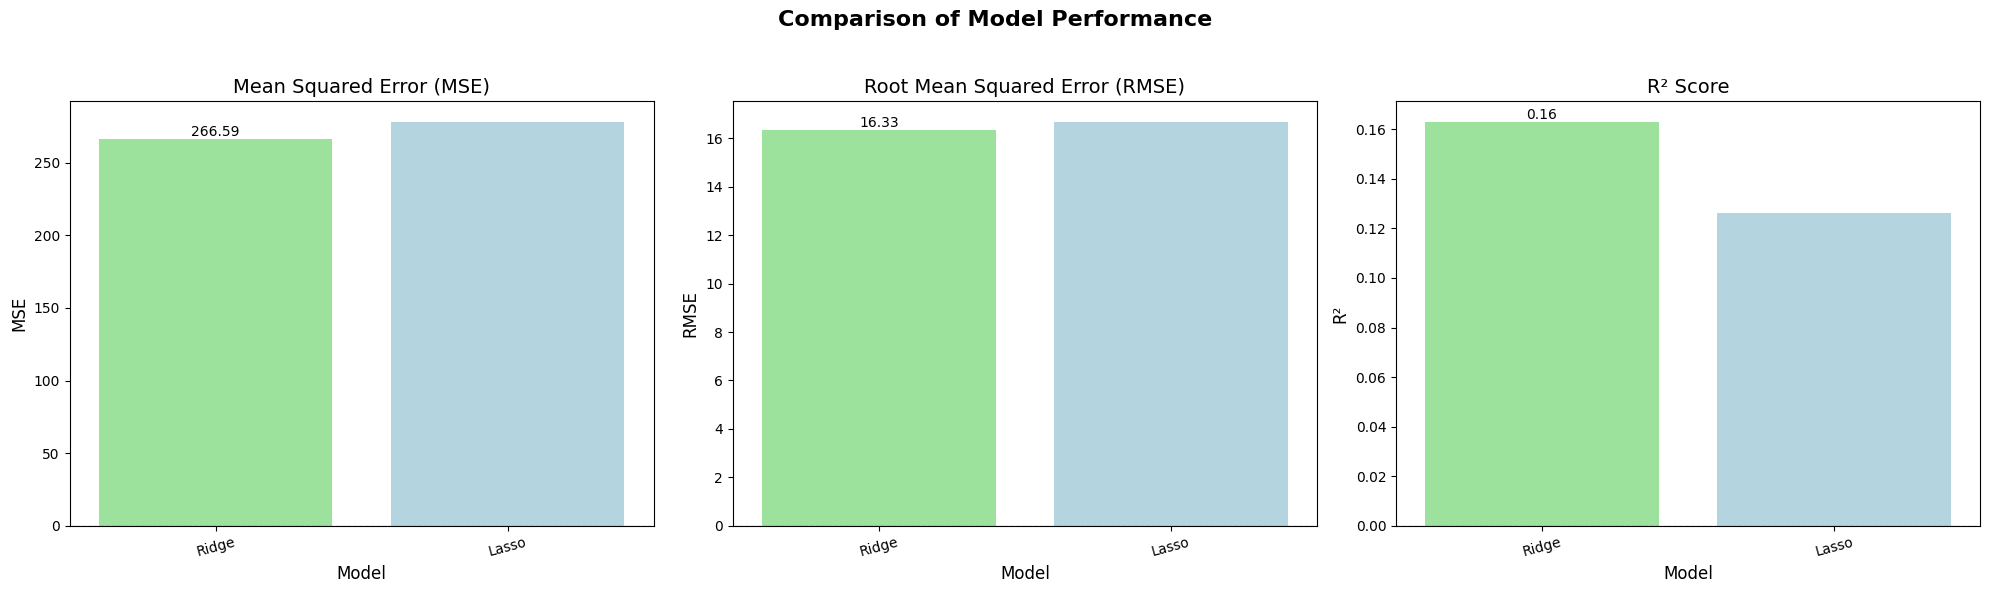


Comparison of Models:
Ridge - MSE: 266.5900, RMSE: 16.3276, R²: 0.1631
Lasso - MSE: 278.3320, RMSE: 16.6833, R²: 0.1262


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Save the results of the models into a dictionary
results = {
    'Model': ['Ridge', 'Lasso'],
    'R²': [ridge_test_r2, lasso_test_r2],
    'MSE': [ridge_test_mse, lasso_test_mse],
    'RMSE': [ridge_test_rmse, lasso_test_rmse]
}

# Select the best model (based on lowest MSE or highest R²)
best_model_index = np.argmin(results['MSE'])  # Select the model with the lowest MSE
best_model_name = results['Model'][best_model_index]
best_model_r2 = results['R²'][best_model_index]
best_model_mse = results['MSE'][best_model_index]
best_model_rmse = results['RMSE'][best_model_index]

# Print the best model results
print(f"Best Model: {best_model_name}")
print(f"Best Model R²: {best_model_r2}")
print(f"Best Model MSE: {best_model_mse}")
print(f"Best Model RMSE: {best_model_rmse}")

# Plot comparison charts for MSE, RMSE, and R² of the models
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Colors to highlight the best model
colors = ['lightblue' if i != best_model_index else 'lightgreen' for i in range(len(results['Model']))]

# MSE Chart
sns.barplot(x=results['Model'], y=results['MSE'], ax=ax[0], palette=colors)
ax[0].set_title('Mean Squared Error (MSE)', fontsize=14)
ax[0].set_xlabel('Model', fontsize=12)
ax[0].set_ylabel('MSE', fontsize=12)
ax[0].bar_label(ax[0].containers[0], fmt='%.2f', fontsize=10)

# RMSE Chart
sns.barplot(x=results['Model'], y=results['RMSE'], ax=ax[1], palette=colors)
ax[1].set_title('Root Mean Squared Error (RMSE)', fontsize=14)
ax[1].set_xlabel('Model', fontsize=12)
ax[1].set_ylabel('RMSE', fontsize=12)
ax[1].bar_label(ax[1].containers[0], fmt='%.2f', fontsize=10)

# R² Chart
sns.barplot(x=results['Model'], y=results['R²'], ax=ax[2], palette=colors)
ax[2].set_title('R² Score', fontsize=14)
ax[2].set_xlabel('Model', fontsize=12)
ax[2].set_ylabel('R²', fontsize=12)
ax[2].bar_label(ax[2].containers[0], fmt='%.2f', fontsize=10)

# Highlight the best model
for a in ax:
    a.axhline(0, color='black', linewidth=0.8, linestyle='--')
    a.tick_params(axis='x', labelrotation=15)

plt.suptitle('Comparison of Model Performance', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Print a comparison table
print("\nComparison of Models:")
for model, mse, rmse, r2 in zip(results['Model'], results['MSE'], results['RMSE'], results['R²']):
    print(f"{model} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

### Explain Code

1. **Importing Libraries**
   - **matplotlib.pyplot (`plt`) and seaborn (`sns`):**
     - **Purpose:** Facilitate data visualization by providing a wide range of plotting functions.
     - **Usage:** Used to create bar plots that compare the performance metrics of different regression models.
   - **NumPy (`np`):**
     - **Purpose:** Supports numerical operations and handling of array data.
     - **Usage:** Utilized to identify the index of the model with the lowest Mean Squared Error (MSE).

2. **Storing Model Results**
   - **Creating a Results Dictionary:**
     - **Structure:** Contains lists for each model's name (`Model`), R-squared scores (`R²`), Mean Squared Error (`MSE`), and Root Mean Squared Error (`RMSE`).
     - **Purpose:** Organizes the performance metrics of each regression model (Ridge and Lasso) for easy access and comparison.

3. **Selecting the Best Model**
   - **Identifying the Best Model Based on MSE:**
     - **Method:** Uses NumPy's `argmin` function to find the index of the model with the lowest MSE.
     - **Selection:** Determines which model (Ridge or Lasso) performs best by having the smallest MSE value.
   - **Extracting Best Model Metrics:**
     - **Details:** Retrieves the name, R², MSE, and RMSE of the best-performing model using the identified index.
   - **Displaying Best Model Information:**
     - **Output:** Prints the name of the best model along with its corresponding R², MSE, and RMSE values to the console for quick reference.

4. **Visualizing Model Performance**
   - **Setting Up the Plot:**
     - **Figure and Axes Creation:** Initializes a figure with three subplots arranged horizontally to display bar charts for MSE, RMSE, and R².
     - **Color Highlighting:** Assigns distinct colors to each model's bars, highlighting the best model with a different color to make it stand out.
   - **Creating Bar Plots:**
     - **MSE Plot:**
       - **Description:** Visualizes the Mean Squared Error of each model.
       - **Customization:** Sets titles and labels for clarity and adds numerical labels above each bar for precise values.
     - **RMSE Plot:**
       - **Description:** Displays the Root Mean Squared Error of each model.
       - **Customization:** Similar to the MSE plot, with appropriate titles and labels.
     - **R² Plot:**
       - **Description:** Shows the R-squared scores of each model.
       - **Customization:** Consistent styling with the other plots, including titles and labels.
   - **Finalizing the Plot:**
     - **Reference Lines:** Adds horizontal dashed lines at zero to serve as a baseline.
     - **Axis Adjustments:** Rotates x-axis labels slightly for better readability.
     - **Overall Title and Layout:** Adds a main title to the figure and adjusts the layout to prevent overlap, ensuring a clean and organized presentation.
     - **Display:** Renders the complete visualization to the screen.

5. **Printing a Comparison Table**
   - **Displaying Model Metrics:**
     - **Format:** Iterates through each model and prints its MSE, RMSE, and R² in a formatted string.
     - **Purpose:** Provides a clear, textual comparison of each model's performance metrics directly in the console for easy interpretation.


#### Comment about result
- The Ridge model has a slightly lower MSE, RMSE than the Lasso model. This indicates that, on average, the Ridge model's predictions are closer to the actual values compared to the Lasso model.
- The Ridge model also has a higher R-squared score. This means that the Ridge model explains a greater proportion of the variance in the target variable than the Lasso model.

### References

1. **Ridge Regression**
   - [Ridge Regression - Wikipedia](https://en.wikipedia.org/wiki/Ridge_regression)

2. **Lasso Regression**
   - [Lasso Regression - IBM](https://www.ibm.com/think/topics/lasso-regression#:~:text=Lasso%20regression%20is%20a%20regularization,regularization%20for%20linear%20regression%20models.)